<a href="https://colab.research.google.com/github/hazelhkim/Pytorch/blob/master/Custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Binary Classification

Load Dataset from sklearn

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [11]:
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target
df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.256,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.463,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.075,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.595,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,0.3857,1.428,2.548,19.15,0.007189,0.00466,0.00000,0.00000,0.02676,0.002783,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


In [12]:
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'class'],
      dtype='object')

Convert to PyTorch Tensor

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

data = torch.from_numpy(df.values).float()
data.shape

torch.Size([569, 31])

In [14]:
x = data[:, :10]
y = data[:, -1:]
print(x.shape, y.shape)

torch.Size([569, 10]) torch.Size([569, 1])


In [15]:
# Train/ Valid/ Test Ratio
ratios = [.6, .2, .2]

train_cnt = int(data.size(0)*ratios[0])
valid_cnt = int(data.size(0)*ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples." %(train_cnt, valid_cnt, test_cnt))

Train 341 / Valid 113 / Test 115 samples.


In [16]:
# You don't need to shuffle them, if you have fixed train/valid/test set.
indices = torch.randperm(data.size(0))
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = x.split(cnts, dim=0)
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x, y):
  print(x_i.size(), y_i.size())

torch.Size([341, 10]) torch.Size([341, 1])
torch.Size([113, 10]) torch.Size([113, 1])
torch.Size([115, 10]) torch.Size([115, 1])


Set Hyperparameters

In [17]:
n_epochs = 10000
batch_size = 128
print_interval = 500
early_stop = 100

Get DataLoaders

In [18]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels

    super().__init__()

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [20]:
train_loader = DataLoader(
    dataset = CustomDataset(x[0], y[0]),
    batch_size = batch_size,
    shuffle = True, # Allow shuffling only for training set.
)

valid_loader = DataLoader(
    dataset = CustomDataset(x[1], y[1]),
    batch_size = batch_size,
    shuffle = False,
)

test_loader = DataLoader(
    dataset = CustomDataset(x[2], y[2]),
    batch_size = batch_size,
    shuffle = False,
)

print("Train %d / Valid %d / Test %d samples." %(
    len(train_loader.dataset),
    len(valid_loader.dataset),
    len(test_loader.dataset),
))

Train 341 / Valid 113 / Test 115 samples.


# Build Model & Optimizer

In [21]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
    nn.Sigmoid(),
)

model

Sequential(
  (0): Linear(in_features=10, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
  (9): Sigmoid()
)

In [22]:
optimizer = optim.Adam(model.parameters())

# Train

In [23]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

In [24]:
train_history, valid_history = [], []

for i in range(n_epochs):
  model.train()
  train_loss, valid_loss = 0, 0
  y_hat = []

  for x_i, y_i in train_loader:
    y_hat_i = model(x_i)
    loss = F.binary_cross_entropy(y_hat_i, y_i)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += float(loss) # This is very important to prevent memory leak.

  train_loss = train_loss / len(train_loader)

  model.eval()
  with torch.no_grad():
    valid_loss = 0

    for x_i, y_i in valid_loader:
      y_hat_i = model(x_i)
      loss = F.binary_cross_entropy(y_hat_i, y_i)
      valid_loss += float(loss)
      y_hat += [y_hat_i]

  train_history += [train_loss]
  valid_history += [valid_loss]

  if (i+1) % print_interval == 0:
    print('Epoch %d: train loss = %.4e  valid_loss = %.4e  lowest_loss=%.4e' %(
        i + 1, 
        train_loss,
        valid_loss,
        lowest_loss,
    ))
    
  if valid_loss <= lowest_loss:
    lowest_loss = valid_loss
    lowest_epoch = i

    best_model = deepcopy(model.state_dict())
  else:
    if early_stop > 0 and lowest_epoch + early_stop < i + 1:
      print("There is no improvement during last %d epochs." %early_stop)
      break
  
print("The best validation loss from epoch %d: %.4e" %(
    lowest_epoch + 1, lowest_loss
))

model.load_state_dict(best_model)

Epoch 500: train loss = 3.1133e-01  valid_loss = 2.9596e-01  lowest_loss=2.8926e-01
Epoch 1000: train loss = 2.7441e-01  valid_loss = 2.5634e-01  lowest_loss=2.5403e-01
Epoch 1500: train loss = 2.2794e-01  valid_loss = 2.1525e-01  lowest_loss=2.1599e-01
Epoch 2000: train loss = 1.6208e-01  valid_loss = 1.7785e-01  lowest_loss=1.7387e-01
There is no improvement during last 100 epochs.
The best validation loss from epoch 2397: 1.6785e-01


<All keys matched successfully>

## Loss History

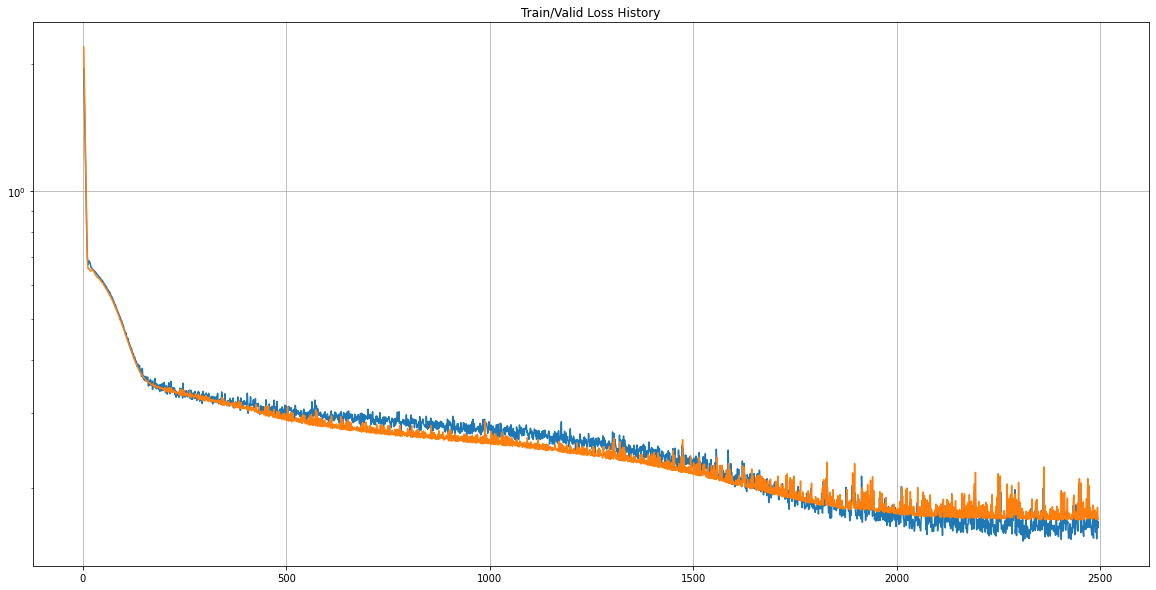

In [25]:
plot_from = 2

plt.figure(figsize = (20, 10))
plt.grid(True)
plt.title("Train/Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

Let's see the result!

In [27]:
test_loss = 0
y_hat = []

model.eval()
with torch.no_grad():
  for x_i, y_i in test_loader:
    y_hat_i = model(x_i)
    loss = F.binary_cross_entropy(y_hat_i, y_i)
    test_loss += loss # Gradient is already detached.
    y_hat += [y_hat_i]

test_loss = test_loss / len(test_loader)
y_hat = torch.cat(y_hat, dim=0)

print("Test loss: %.4e" % test_loss)

Test loss: 1.2768e-01


In [28]:
correct_cnt = (y[2] == (y_hat > .5)).sum()
total_cnt = float(y[2].size(0))

print('Test Accuracy: %.4f' %(correct_cnt/total_cnt))

Test Accuracy: 0.9565
